## CLASSIFYING CLINICALLY ACTIONABLE GENETIC MUTATIONS

### ABSTRACT

* Aim of this project is to predict the genetic mutation classes from the given gene, the type of variation in the gene and the clinical evidences regarding the possibly occuring mutation

* The target variable is a distinct valued column, meaning this is multiclass classification problem

* Various Classification models are used to train the data such as Naive Bayes, Support Vector Machines, Logistic Regression, etc.

* Evaluation metric used is log loss

### DESCRIPTION

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

### ACKNOWLEDGEMENT

This dataset was provided by Memorial Sloan Kettering Cancer Center (MSKCC) to help take personalized medicine to its full potential

### DATASET

Fields are:

1. ID : the id of the row used to link the mutation to the clinical evidence

2. Gene :the gene where this genetic mutation is located

3. Variation :the aminoacid change for this mutations

4. Class : 1-9 the class this genetic mutation has been classified on

5. test_variants : a comma separated file containing the description of the genetic mutations used for training

In [1]:
# Loading all required packages
# If any of it fails, do not panic. Just install it using "pip3 install <package_name>" or by using conda install package_name
import re
import time
import warnings
from collections import Counter, defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
import gensim
from gensim import models
from gensim.models import KeyedVectors, Word2Vec
import nltk
from nltk.corpus import stopwords
warnings.filterwarnings("ignore")

Importing the csv for gene, variation and class file and the text file

In [2]:
data_variants = pd.read_csv('training_variants')
data_text = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [3]:
data_variants.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


Each of these combinations of gene and variations is unique. 

In [4]:
df=data_variants.drop_duplicates()
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


##### Text Data before pre-processing it

In [5]:
data_text.head(5)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
df.drop_duplicates()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [7]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [8]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [9]:
data_variants.shape

(3321, 4)

In [10]:
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [11]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [12]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [13]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [14]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [15]:
data_text.shape

(3321, 2)

In [16]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

Downloading stopwords from the nltk library

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/apurvasalvi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

##### Performing Text Preporocessing

In [20]:
def text_preprocessing(text_file, col, ind):
    # Remove int values from text data as that might not be imp
    if type(text_file) is not int:
        string = ""
        #converting the text to lower case
        text_file = text_file.lower()
        #replacing special characters with spaces
        text_file = re.sub('[^a-zA-Z0-9\n]', ' ', str(text_file))
        #replacing multiple spaces with single space
        text_file = re.sub('\s+',' ', str(text_file))
        
        for word in text_file.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [21]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], 'TEXT', index)

In [22]:
data_text.head(10)

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
5,5,oncogenic mutations monomeric casitas b lineag...
6,6,oncogenic mutations monomeric casitas b lineag...
7,7,cbl negative regulator activated receptor tyro...
8,8,abstract juvenile myelomonocytic leukemia jmml...
9,9,abstract juvenile myelomonocytic leukemia jmml...


In [23]:
data_text.shape

(3321, 2)

Merging the data_variants and the data_text file

In [24]:
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


Checking for NaN in the merged data

In [25]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


Replacing the NaN with the value of Gene and Variation for the corresponding row

In [26]:
result.loc[result['TEXT'].isnull(), 'TEXT'] = result['Gene'] +' '+result['Variation']

In [27]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


Replacing any spaces present in the Gene Variation Column by '_'

In [28]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

###  TRAIN TEST VALIDATION

In [29]:
# Splitting the data into train and test set 
X_train, X_test, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

In [30]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])

Number of data points in train data: 2656
Number of data points in test data: 665


#### CHECKING IF THE CLASSES ARE DISTRIBUTED EVENLY THROUGHOUT THE DATASET

In [31]:
train_class_distribution = X_train['Class'].value_counts().sort_index()
test_class_distribution = X_test['Class'].value_counts().sort_index()

In [32]:
print("Train class Distribution\n", train_class_distribution)
print("Test Class Distribution\n", test_class_distribution)

Train class Distribution
 1    454
2    361
3     71
4    549
5    194
6    220
7    762
8     15
9     30
Name: Class, dtype: int64
Test Class Distribution
 1    114
2     91
3     18
4    137
5     48
6     55
7    191
8      4
9      7
Name: Class, dtype: int64


#### LOOKING AT THE DISTRIBUTION OF THE DATA IN TRAIN AND TEST SET

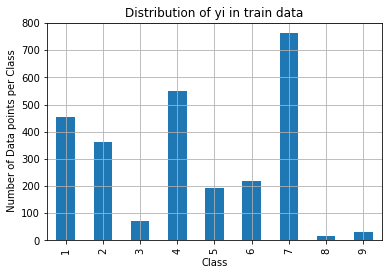

In [33]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

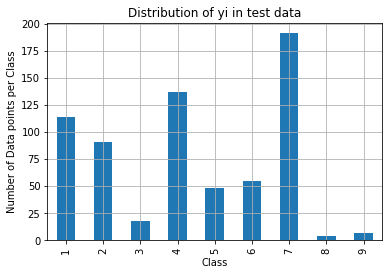

In [34]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

#### BUILDING A RANDOM MODEL

With evaluation matrix as log loss, this value can range from [0, infinity)


We need something to compare the values of log loss therefore, I have built a random model.

In [35]:
test_data_len = X_test.shape[0]

In [36]:
y_pred = np.zeros((test_data_len, 9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1, 9)
    y_pred[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss in Text Data using Random Model", log_loss(y_test,y_pred, eps=1e-15))

Log loss in Text Data using Random Model 2.5388417106609857


In [37]:
predicted_y = np.argmax(y_pred, axis=1)

In [38]:
predicted_y

array([1, 4, 8, 2, 7, 8, 0, 3, 1, 7, 6, 2, 3, 0, 2, 4, 4, 7, 8, 6, 6, 6,
       3, 3, 6, 8, 3, 6, 1, 1, 5, 4, 8, 4, 4, 8, 4, 8, 8, 3, 8, 6, 0, 0,
       6, 0, 0, 6, 7, 6, 2, 8, 6, 0, 7, 2, 1, 5, 3, 3, 6, 8, 6, 2, 2, 2,
       4, 5, 2, 8, 8, 5, 2, 8, 0, 7, 5, 7, 0, 0, 5, 8, 1, 2, 8, 5, 7, 4,
       7, 1, 6, 5, 7, 5, 4, 3, 3, 1, 2, 6, 4, 3, 8, 2, 3, 5, 5, 1, 2, 3,
       4, 7, 7, 3, 1, 3, 0, 1, 7, 5, 6, 2, 7, 0, 4, 3, 8, 7, 0, 1, 0, 6,
       3, 4, 3, 7, 7, 7, 1, 8, 0, 1, 4, 6, 4, 5, 1, 4, 7, 5, 8, 2, 4, 6,
       3, 1, 4, 7, 2, 0, 8, 1, 3, 7, 7, 4, 2, 8, 7, 5, 1, 0, 4, 7, 6, 5,
       2, 1, 8, 8, 3, 1, 4, 0, 2, 8, 7, 6, 1, 4, 5, 2, 5, 5, 0, 6, 3, 4,
       5, 1, 3, 5, 6, 7, 6, 5, 6, 1, 0, 1, 7, 1, 7, 0, 4, 2, 0, 4, 6, 8,
       5, 0, 0, 7, 8, 1, 6, 8, 0, 8, 5, 7, 2, 3, 2, 0, 2, 5, 2, 4, 2, 6,
       0, 5, 2, 6, 2, 7, 8, 0, 2, 0, 5, 4, 7, 8, 2, 1, 4, 7, 6, 8, 1, 1,
       8, 1, 2, 5, 6, 5, 1, 3, 4, 1, 0, 4, 2, 6, 7, 5, 1, 7, 3, 0, 2, 8,
       5, 0, 8, 0, 5, 4, 4, 4, 4, 1, 6, 3, 7, 1, 8,

In [39]:
predicted_y = predicted_y + 1
predicted_y

array([2, 5, 9, 3, 8, 9, 1, 4, 2, 8, 7, 3, 4, 1, 3, 5, 5, 8, 9, 7, 7, 7,
       4, 4, 7, 9, 4, 7, 2, 2, 6, 5, 9, 5, 5, 9, 5, 9, 9, 4, 9, 7, 1, 1,
       7, 1, 1, 7, 8, 7, 3, 9, 7, 1, 8, 3, 2, 6, 4, 4, 7, 9, 7, 3, 3, 3,
       5, 6, 3, 9, 9, 6, 3, 9, 1, 8, 6, 8, 1, 1, 6, 9, 2, 3, 9, 6, 8, 5,
       8, 2, 7, 6, 8, 6, 5, 4, 4, 2, 3, 7, 5, 4, 9, 3, 4, 6, 6, 2, 3, 4,
       5, 8, 8, 4, 2, 4, 1, 2, 8, 6, 7, 3, 8, 1, 5, 4, 9, 8, 1, 2, 1, 7,
       4, 5, 4, 8, 8, 8, 2, 9, 1, 2, 5, 7, 5, 6, 2, 5, 8, 6, 9, 3, 5, 7,
       4, 2, 5, 8, 3, 1, 9, 2, 4, 8, 8, 5, 3, 9, 8, 6, 2, 1, 5, 8, 7, 6,
       3, 2, 9, 9, 4, 2, 5, 1, 3, 9, 8, 7, 2, 5, 6, 3, 6, 6, 1, 7, 4, 5,
       6, 2, 4, 6, 7, 8, 7, 6, 7, 2, 1, 2, 8, 2, 8, 1, 5, 3, 1, 5, 7, 9,
       6, 1, 1, 8, 9, 2, 7, 9, 1, 9, 6, 8, 3, 4, 3, 1, 3, 6, 3, 5, 3, 7,
       1, 6, 3, 7, 3, 8, 9, 1, 3, 1, 6, 5, 8, 9, 3, 2, 5, 8, 7, 9, 2, 2,
       9, 2, 3, 6, 7, 6, 2, 4, 5, 2, 1, 5, 3, 7, 8, 6, 2, 8, 4, 1, 3, 9,
       6, 1, 9, 1, 6, 5, 5, 5, 5, 2, 7, 4, 8, 2, 9,

##### Function to plot a Confusion Matrix, Precision Matrix and Recall Matrix

In [40]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    labels=[1, 2, 3, 4, 5, 6, 7, 8, 9]
    sns.heatmap(C, annot=True, cmap="YlGnBu",fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


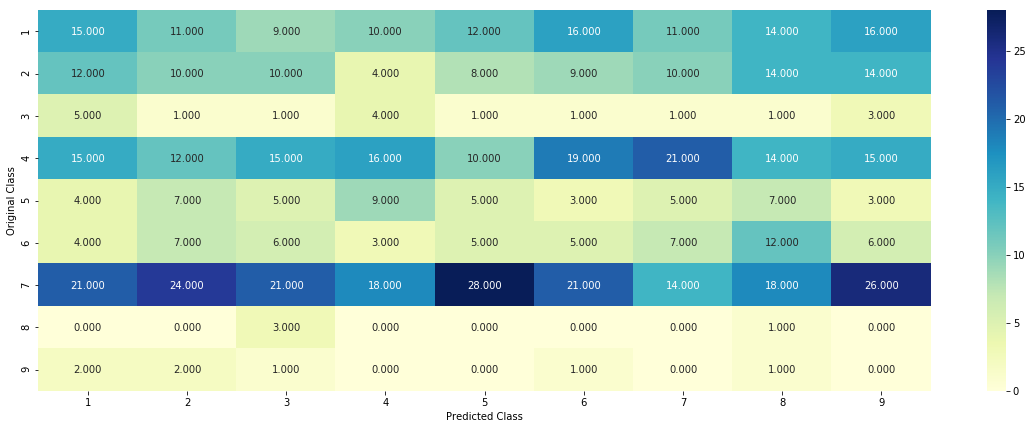

In [41]:
plot_confusion_matrix(y_test, predicted_y)

### EVALUATING THE GENE COLUMN

In [42]:
unique_genes = X_train['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 246
BRCA1     212
TP53      126
EGFR      106
PTEN      100
BRCA2      93
KIT        79
BRAF       73
ALK        59
ERBB2      57
PDGFRA     53
Name: Gene, dtype: int64


In [43]:
unique_genes.shape[0]

246

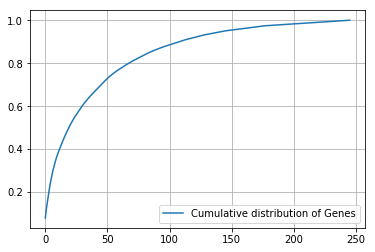

In [44]:
s = sum(unique_genes.values)
h = unique_genes.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

From the above distribution we can say that for the top 50 unique gene values represents 75% of the data

#### DEALING WITH CATEGORICAL VARIABLES

The variables in the Gene column are all categorical. There are two methods to convert categorical variable to an appropriate form from which the machine will be able to take an input as.


There are 2 methods to do that:
1. One Hot Encoding
2. Response Encoding (Mean Imputation)

#### ONE HOT ENCODING ON THE GENE COLUMN

In [45]:
gene_vectorizer = CountVectorizer()
train_gene_onehotencoding = gene_vectorizer.fit_transform(X_train['Gene'])
test_gene_onehotencoding = gene_vectorizer.transform(X_test['Gene'])

In [46]:
train_gene_onehotencoding.shape

(2656, 245)

In [47]:
test_gene_onehotencoding.shape

(665, 245)

In [48]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 '

##### FITTING THE MODE WITH ONLY GENE FEATURE AND EXAMINING THE LOG-LOSS FOR DIFFERENT VALUES OF ALPHA

In [49]:
alpha = [10 ** x for x in range(-5, 1)]

In [50]:
train_logloss_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_onehotencoding, y_train)
    sigmoid_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sigmoid_clf.fit(train_gene_onehotencoding, y_train)
    predict_y = sigmoid_clf.predict_proba(train_gene_onehotencoding)
    train_logloss_error_array.append(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    print('For value of alpha = ', i, "The log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

For value of alpha =  1e-05 The log loss is: 1.2312377789653366
For value of alpha =  0.0001 The log loss is: 1.0325928025284061
For value of alpha =  0.001 The log loss is: 1.1046158111453497
For value of alpha =  0.01 The log loss is: 1.2723069675874625
For value of alpha =  0.1 The log loss is: 1.3953638266683597
For value of alpha =  1 The log loss is: 1.4370549753218478


##### TRAINING THE MODEL WITH THE BEST VALUE OF ALPHA

A Calibrated Classifier is used to convert these values into probabilities since we need to calculate log-loss which needs probability

In [51]:
best_alpha = np.argmin(train_logloss_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_onehotencoding, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

In [52]:
y_pred_train = sig_clf.predict_proba(train_gene_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, y_pred_train, labels=clf.classes_, eps=1e-15))
y_pred_test = sig_clf.predict_proba(test_gene_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, y_pred_test, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 1.0325928025284061
For values of best alpha =  0.0001 The test log loss is: 1.1917818444183492


#### EVALUATING FOR VARIATION COLUMN

In [53]:
unique_variations = X_train['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
print(unique_variations.head(10))

Number of Unique Variations : 2407
Truncating_Mutations    72
Deletion                66
Amplification           48
Fusions                 28
Overexpression           5
E17K                     3
Q61R                     3
F384L                    2
P34R                     2
Q61L                     2
Name: Variation, dtype: int64


Cumulative distribution of Variations

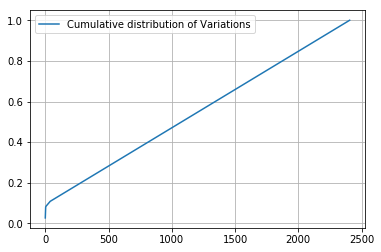

In [54]:
s = sum(unique_variations.values)
h = unique_variations.values/s
c = np.cumsum(h)
plt.plot(c, label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

#### ONE HOT ENCODING ON VARIATION COLUMN

In [55]:
variation_vectorizer = CountVectorizer()
train_variation_onehotencoding = variation_vectorizer.fit_transform(X_train['Variation'])
test_variation_onehotencoding = variation_vectorizer.transform(X_test['Variation'])

In [56]:
train_variation_onehotencoding.shape

(2656, 2441)

In [57]:
test_variation_onehotencoding.shape

(665, 2441)

##### FITTING THE MODE WITH ONLY VARIATION FEATURE AND EXAMINING THE LOG-LOSS FOR DIFFERENT VALUES OF ALPHA

In [58]:
alpha = [10 ** x for x in range(-5, 1)]
train_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_onehotencoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_onehotencoding, y_train)
    predict_y = sig_clf.predict_proba(train_variation_onehotencoding)
    train_log_error_array.append(log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 0.7660995718084662
For values of alpha =  0.0001 The log loss is: 0.8095199502882785
For values of alpha =  0.001 The log loss is: 1.1689510006143686
For values of alpha =  0.01 The log loss is: 1.4693169262883838
For values of alpha =  0.1 The log loss is: 1.5825622522794882
For values of alpha =  1 The log loss is: 1.5870936194624112


##### TRAINING THE MODEL WITH THE BEST VALUE OF ALPHA

In [59]:
best_alpha = np.argmin(train_logloss_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_onehotencoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_onehotencoding, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
            cv='warn', method='sigmoid')

In [60]:
predict_y = sig_clf.predict_proba(train_variation_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))

predict_y = sig_clf.predict_proba(test_variation_onehotencoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.8095199502882785
For values of best alpha =  0.0001 The test log loss is: 1.703424673512173


#### EVALUATING TEXT COLUMN

##### ONE HOT ENCODING THE TEXT COLUMN.

Finding the term frequency for each word in each document using the Count Vectorizer and then putting the encoded term value with it's frequency value in a dictionary.

In [61]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(X_train['TEXT'])
test_text_feature_onehotCoding = text_vectorizer.transform(X_test['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features), train_text_fea_counts))

print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 59873


The term frequency dictionary 

In [62]:
text_fea_dict

{'00': 2993,
 '000': 7038,
 '0000': 8,
 '00000001': 8,
 '0000001': 10,
 '000001': 26,
 '000002': 16,
 '000007': 14,
 '00001': 29,
 '000011': 5,
 '000012': 5,
 '000017': 4,
 '00002644': 6,
 '000038': 8,
 '00005': 12,
 '000059': 8,
 '00006': 3,
 '000077': 86,
 '00009': 6,
 '0001': 1817,
 '000132': 22,
 '00014': 6,
 '000141': 12,
 '00016': 5,
 '000179': 15,
 '000182': 3,
 '0001a': 18,
 '0002': 156,
 '0002158': 16,
 '00023490': 3,
 '000245': 19,
 '000249': 19,
 '000251': 17,
 '000258': 12,
 '000267': 34,
 '00029': 6,
 '0003': 93,
 '00034': 5,
 '000369266': 49,
 '00037': 7,
 '0004': 77,
 '0005': 105,
 '000535': 15,
 '000546': 3,
 '000548': 76,
 '000588': 12,
 '0006': 65,
 '0007': 37,
 '0008': 231,
 '00088': 6,
 '0009': 23,
 '00092': 5,
 '000g': 107,
 '000xg': 10,
 '001': 3037,
 '0010': 17,
 '001012496': 3,
 '00103': 3,
 '0011': 21,
 '001100': 3,
 '001105': 6,
 '001172713': 4,
 '001198': 7,
 '0012': 46,
 '001269551': 4,
 '0012a': 3,
 '0013': 76,
 '0014': 74,
 '001429': 3,
 '0014b': 6,
 '0015

In [63]:
train_text_feature_onehotCoding

<2656x59873 sparse matrix of type '<class 'numpy.int64'>'
	with 4137195 stored elements in Compressed Sparse Row format>

In [64]:
text_fea_dict

{'00': 2993,
 '000': 7038,
 '0000': 8,
 '00000001': 8,
 '0000001': 10,
 '000001': 26,
 '000002': 16,
 '000007': 14,
 '00001': 29,
 '000011': 5,
 '000012': 5,
 '000017': 4,
 '00002644': 6,
 '000038': 8,
 '00005': 12,
 '000059': 8,
 '00006': 3,
 '000077': 86,
 '00009': 6,
 '0001': 1817,
 '000132': 22,
 '00014': 6,
 '000141': 12,
 '00016': 5,
 '000179': 15,
 '000182': 3,
 '0001a': 18,
 '0002': 156,
 '0002158': 16,
 '00023490': 3,
 '000245': 19,
 '000249': 19,
 '000251': 17,
 '000258': 12,
 '000267': 34,
 '00029': 6,
 '0003': 93,
 '00034': 5,
 '000369266': 49,
 '00037': 7,
 '0004': 77,
 '0005': 105,
 '000535': 15,
 '000546': 3,
 '000548': 76,
 '000588': 12,
 '0006': 65,
 '0007': 37,
 '0008': 231,
 '00088': 6,
 '0009': 23,
 '00092': 5,
 '000g': 107,
 '000xg': 10,
 '001': 3037,
 '0010': 17,
 '001012496': 3,
 '00103': 3,
 '0011': 21,
 '001100': 3,
 '001105': 6,
 '001172713': 4,
 '001198': 7,
 '0012': 46,
 '001269551': 4,
 '0012a': 3,
 '0013': 76,
 '0014': 74,
 '001429': 3,
 '0014b': 6,
 '0015

In [65]:
train_text_feature_onehotCoding

<2656x59873 sparse matrix of type '<class 'numpy.int64'>'
	with 4137195 stored elements in Compressed Sparse Row format>

Normalizing the data such that the input vectors are individually scaled to unit norm

In [66]:
# normalizing every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

In [67]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

#### BAG OF WORDS

One hot Encoded elements are stored as dictionary keys and their counts as dictionary values thus creating a bag of words

In [68]:
print(Counter(sorted_text_occur))

Counter({3: 6477, 4: 4238, 5: 3095, 6: 3023, 7: 2418, 8: 2302, 10: 1711, 9: 1698, 12: 1410, 11: 1252, 16: 1137, 13: 1020, 14: 1007, 18: 863, 20: 833, 15: 795, 17: 709, 24: 678, 21: 610, 19: 538, 22: 474, 30: 447, 25: 418, 28: 392, 26: 390, 23: 372, 27: 339, 29: 329, 50: 320, 34: 317, 35: 305, 32: 302, 31: 302, 36: 301, 40: 277, 42: 259, 33: 252, 37: 236, 64: 229, 39: 229, 48: 210, 45: 203, 38: 194, 53: 190, 44: 189, 43: 186, 41: 185, 52: 182, 54: 175, 51: 175, 49: 174, 46: 166, 60: 164, 56: 161, 70: 148, 47: 148, 57: 142, 65: 138, 68: 134, 66: 126, 71: 120, 69: 119, 55: 116, 67: 112, 62: 110, 80: 109, 58: 106, 85: 105, 76: 104, 61: 103, 79: 101, 59: 101, 72: 98, 63: 96, 74: 94, 81: 92, 77: 92, 78: 86, 75: 84, 84: 81, 73: 81, 82: 79, 91: 78, 88: 76, 87: 75, 96: 73, 93: 71, 83: 71, 100: 70, 98: 70, 106: 69, 97: 68, 108: 67, 90: 67, 89: 67, 86: 67, 94: 66, 112: 62, 104: 62, 114: 61, 95: 61, 130: 57, 126: 56, 105: 56, 116: 55, 113: 55, 102: 55, 120: 54, 103: 54, 128: 53, 99: 53, 92: 52, 12

### COMBINING ALL 3 FEATURE VECTORS TOGETHER

#### ONE HOT ENCODING

In [69]:
train_x_onehotencoding = hstack((train_gene_onehotencoding, train_variation_onehotencoding))
test_x_onehotencoding = hstack((test_gene_onehotencoding, test_variation_onehotencoding))

train_x_onehotencoding = hstack((train_x_onehotencoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(y_train))

test_x_onehotencoding = hstack((test_x_onehotencoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(y_test))

In [71]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotencoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotencoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2656, 62559)
(number of data points * number of features) in test data =  (665, 62559)


It is evident that the One Hot Encoding generates more feature variables than Response Encoding

### BUILDING A MACHINE LEARNING MODEL

### MULTINOMIAL NAÏVE BAYES

##### LOG-LOSS CALCULATED USING THE ONE HOT ENCODED DATA WITH THE TEXT FILE REPRESENTED AS A BAG OF WORDS

In [72]:
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_logloss_error_array = []
for i in alpha:
    print("For alpha = ", i)
    classifier = MultinomialNB(alpha=i)
    classifier.fit(train_x_onehotencoding, train_y)
    sig_classifier = CalibratedClassifierCV(classifier, method='sigmoid')
    sig_classifier.fit(train_x_onehotencoding, train_y)
    sig_classifier_probs = sig_classifier.predict_proba(train_x_onehotencoding)
    cv_logloss_error_array.append(log_loss(train_y, sig_classifier_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(train_y, sig_classifier_probs))

For alpha =  1e-06
Log Loss : 0.8165874709530571
For alpha =  1e-05
Log Loss : 0.8255344553929361
For alpha =  0.0001
Log Loss : 0.8423803523179707
For alpha =  0.001
Log Loss : 0.8505783802951417
For alpha =  0.01
Log Loss : 0.8616300382208748
For alpha =  0.1
Log Loss : 0.8761025384913668
For alpha =  1
Log Loss : 0.9141944534219789
For alpha =  10
Log Loss : 1.0857887544823075
For alpha =  100
Log Loss : 1.0976044094913429


In [73]:
best_alpha_index = np.argmin(cv_logloss_error_array)

In [74]:
classifier = MultinomialNB(alpha=alpha[best_alpha])
classifier.fit(train_x_onehotencoding, train_y)
sig_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sig_classifier.fit(train_x_onehotencoding, train_y)
sig_classifier_probs = sig_classifier.predict_proba(test_x_onehotencoding)
print("Log loss: ", log_loss(test_y, sig_classifier_probs))

Log loss:  1.268931126042403


-------------------- Confusion matrix --------------------


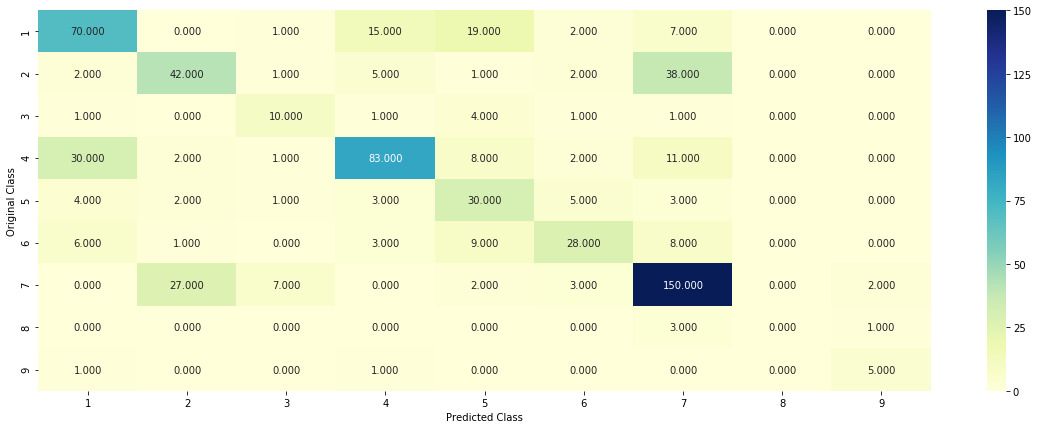

In [75]:
plot_confusion_matrix(test_y, sig_classifier.predict(test_x_onehotencoding.toarray()))

##### Tfidf calculated using TfidfVectorizer

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=15000, min_df=30)
X = tfidfconverter.fit_transform(X_train["TEXT"]).toarray()

In [77]:
X

array([[0.        , 0.02003018, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00822918, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15787236, 0.05131868, 0.01353936, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00164922, 0.        , ..., 0.        , 0.00964878,
        0.        ],
       [0.        , 0.00226422, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00454782, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [78]:
y = tfidfconverter.transform(X_test["TEXT"]).toarray()

Combining the One Hot Encoded Gene and Variation value with the tfidf values for the text

In [79]:
train_x_tfid = hstack((train_gene_onehotencoding, train_variation_onehotencoding))
test_x_tfid = hstack((test_gene_onehotencoding, test_variation_onehotencoding))
train_x_tfid = hstack((train_x_tfid, X)).tocsr()
train_y = np.array(list(y_train))
test_x_tfid = hstack((test_x_tfid, y)).tocsr()
test_y = np.array(list(y_test))

#### FOR TEXT FILE REPRESENTED AS TFIDF

###### TRAINING THE MODEL FOR DIFFERENT VALUES OF THE HYPERPARAMETER ALPHA AND THEN CHOOSING THE BEST VALUE TO PREDICT THE TEST SET OUTPUT

In [80]:
alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
cv_logloss_error_array = []
for i in alpha:
    print("For alpha = ", i)
    classifier = MultinomialNB(alpha=i)
    classifier.fit(train_x_tfid, train_y)
    sig_classifier = CalibratedClassifierCV(classifier, method='sigmoid')
    sig_classifier.fit(train_x_tfid, train_y)
    sig_classifier_probs = sig_classifier.predict_proba(train_x_tfid)
    cv_logloss_error_array.append(log_loss(train_y, sig_classifier_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(train_y, sig_classifier_probs))

For alpha =  1e-06
Log Loss : 0.5716676720382768
For alpha =  1e-05
Log Loss : 0.5808496312031048
For alpha =  0.0001
Log Loss : 0.6020079790036273
For alpha =  0.001
Log Loss : 0.6415569805893105
For alpha =  0.01
Log Loss : 0.6774856672690852
For alpha =  0.1
Log Loss : 0.7693562783624192
For alpha =  1
Log Loss : 1.006055997832656
For alpha =  10
Log Loss : 1.1333970702675495
For alpha =  100
Log Loss : 1.2042328538405926


In [81]:
best_alpha_index = np.argmin(cv_logloss_error_array)

##### LOG LOSS ON THE TESTING SET

In [82]:
classifier = MultinomialNB(alpha=alpha[best_alpha])
classifier.fit(train_x_tfid, train_y)
sig_classifier = CalibratedClassifierCV(classifier, method="sigmoid")
sig_classifier.fit(train_x_tfid, train_y)
sig_classifier_probs = sig_classifier.predict_proba(test_x_tfid)
print("Log loss: ", log_loss(test_y, sig_classifier_probs))

Log loss:  1.2080765438503673


-------------------- Confusion matrix --------------------


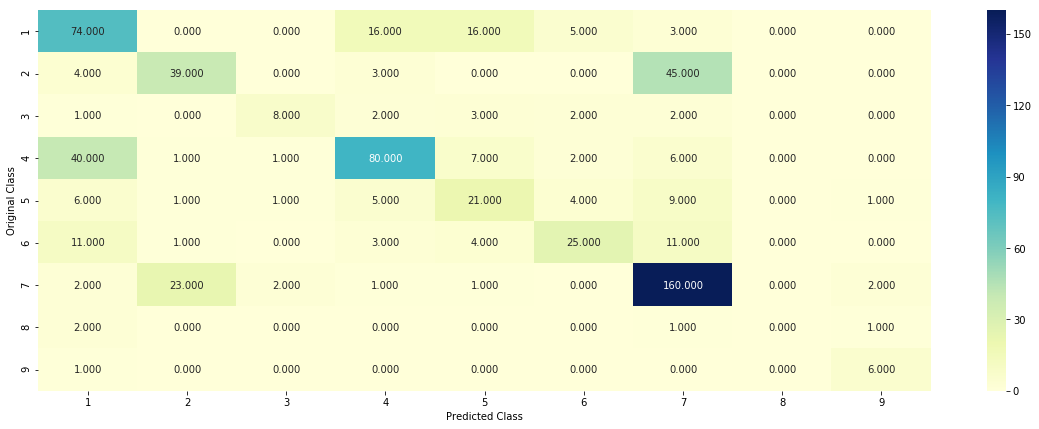

In [83]:
plot_confusion_matrix(test_y, sig_classifier.predict(test_x_tfid.toarray()))

#### REPEATING THE PROCEDURE FOR EVALUATING TEXT COLUMN USING WORD2VEC

In [84]:
w = models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [85]:
url = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(url, binary=True, limit=1000)

In [86]:
def word_2_vec(data):
    docs_vectors = pd.DataFrame()
    stopwords = nltk.corpus.stopwords.words('english')
    for doc in data:
        temp = pd.DataFrame()
        for word in doc.split(' '):
            if word not in stopwords:
                try:
                    word_vec = embeddings[word]
                    temp = temp.append(pd.Series(word_vec), ignore_index=True)
                except:
                    pass
        doc_vector = temp.mean()
        docs_vectors = docs_vectors.append(doc_vector, ignore_index=True)
    return docs_vectors

##### WORD2VEC REPRESENTATION FOR TRAINING SET

In [87]:
a = word_2_vec(X_train['TEXT'])

##### WORD2VEC REPRESENTATION FOR THE TESTING SET

In [88]:
b = word_2_vec(X_test['TEXT'])

In [89]:
a[a.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
a.shape

(2656, 300)

In [91]:
b.shape

(665, 300)

In [97]:
a = a.fillna(0)
b = b.fillna(0)

In [98]:
a[a.isnull().any(axis=1)]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299


In [100]:
train_x_word2vec_ = hstack((train_gene_onehotencoding, train_variation_onehotencoding))
test_x_word2vec_ = hstack((test_gene_onehotencoding, test_variation_onehotencoding))

train_x_word2vec_1 = hstack((train_x_word2vec_, a)).tocsr()
train_y = np.array(list(y_train))

test_x_word2vec_1 = hstack((test_x_word2vec_, b)).tocsr()
test_y = np.array(list(y_test))

In [101]:
train_x_word2vec_1.shape

(2656, 2986)

In [102]:
test_x_word2vec_1.shape

(665, 2986)

#### Multinomial Naive Bayes cannot take negative input values. Therefore, we cannot test word2vec on the Multinomial Naive Bayes as it contains negative values

### TESTING DIFFERENT MODELS

### RANDOM FOREST CLASSIFIER

#### Random Forest Classifier on text data represented as bag of words

In [103]:
param_grid = {'n_estimators': [50, 100, 200, 500],
              'max_depth': [5, 7, 10, 15]
             }
rfc = RandomForestClassifier()
gs_cv = GridSearchCV(rfc, param_grid, n_jobs=4).fit(train_x_onehotencoding, train_y)
gs_cv.best_params_

{'max_depth': 15, 'n_estimators': 200}

In [104]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=100)
rfc.fit(train_x_onehotencoding, train_y)
sig_clf = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf.fit(train_x_onehotencoding, train_y)
predict_y = sig_clf.predict_proba(test_x_onehotencoding)
y_pred = sig_clf.predict_proba(train_x_onehotencoding)
print("The log loss for Random Forest Classifier on Train Data :", log_loss(train_y, y_pred, labels=rfc.classes_, eps=1e-15))
print("The log loss for Random Forest Classifier on Test Data: ", log_loss(y_test, predict_y, labels=rfc.classes_, eps=1e-15))

The log loss for Random Forest Classifier on Train Data : 0.9327815575655326
The log loss for Random Forest Classifier on Test Data:  1.1757745584355377


-------------------- Confusion matrix --------------------


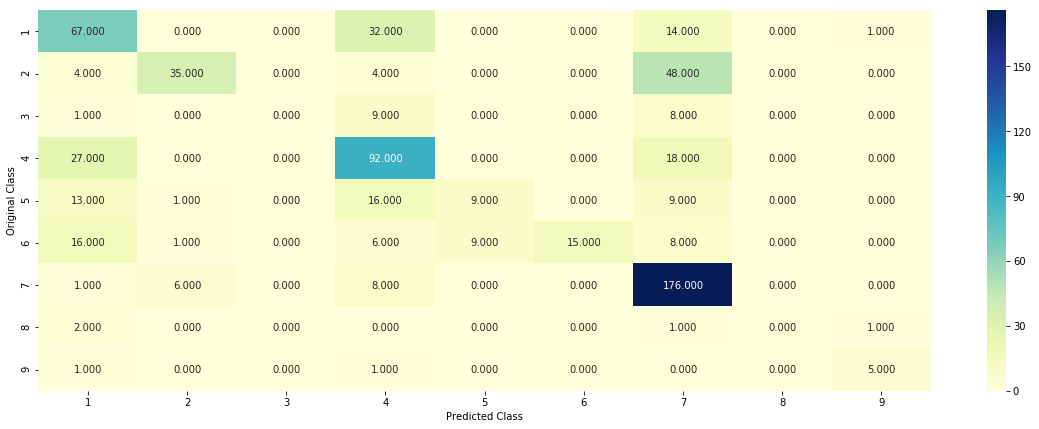

In [105]:
plot_confusion_matrix(y_test, sig_clf.predict(test_x_onehotencoding.toarray()))

#### Random Forest Classifier on text data represented by the TF-IDF scores

In [106]:
rfc = RandomForestClassifier()
gs_cv = GridSearchCV(rfc, param_grid, n_jobs=4).fit(train_x_tfid, train_y)
gs_cv.best_params_

{'max_depth': 15, 'n_estimators': 500}

In [107]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=100)
rfc.fit(train_x_tfid, train_y)
sig_clf = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf.fit(train_x_tfid, train_y)
predict_y = sig_clf.predict_proba(test_x_tfid)
y_pred = sig_clf.predict_proba(train_x_tfid)
print("The log loss for Random Forest Classifier on Train Data :", log_loss(train_y, y_pred))
print("The log loss for Random Forest Classifier on Test Data : ", log_loss(y_test, predict_y))

The log loss for Random Forest Classifier on Train Data : 0.8335977342603907
The log loss for Random Forest Classifier on Test Data :  1.0835303152976545


-------------------- Confusion matrix --------------------


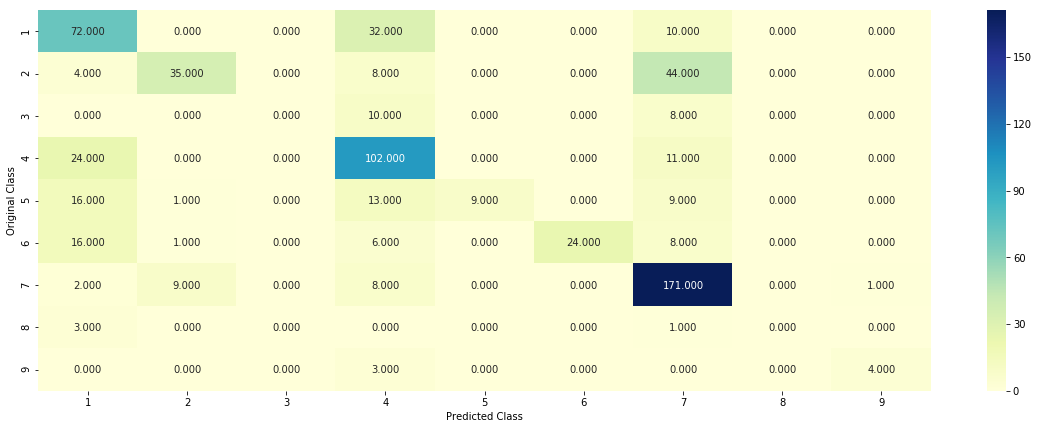

In [108]:
plot_confusion_matrix(y_test, sig_clf.predict(test_x_tfid.toarray()))

#### Random Forest Classifier on text data represented by word2vec

In [109]:
rfc = RandomForestClassifier()
gs_cv = GridSearchCV(rfc, param_grid, n_jobs=4).fit(train_x_word2vec_1, train_y)
gs_cv.best_params_

{'max_depth': 15, 'n_estimators': 500}

In [110]:
rfc = RandomForestClassifier(max_depth=7, n_estimators=100)
rfc.fit(train_x_word2vec_1, train_y)
sig_clf = CalibratedClassifierCV(rfc, method="sigmoid")
sig_clf.fit(train_x_word2vec_1, train_y)
predict_y = sig_clf.predict_proba(test_x_word2vec_1)
print("The log loss for Random Forest Classifier on train data: ", log_loss(train_y, sig_clf.predict_proba(train_x_word2vec_1)))
print("The log loss for Random Forest Classifier on test data: ", log_loss(y_test, predict_y))

The log loss for Random Forest Classifier on train data:  0.9451298165671431
The log loss for Random Forest Classifier on test data:  1.2148346517676634


-------------------- Confusion matrix --------------------


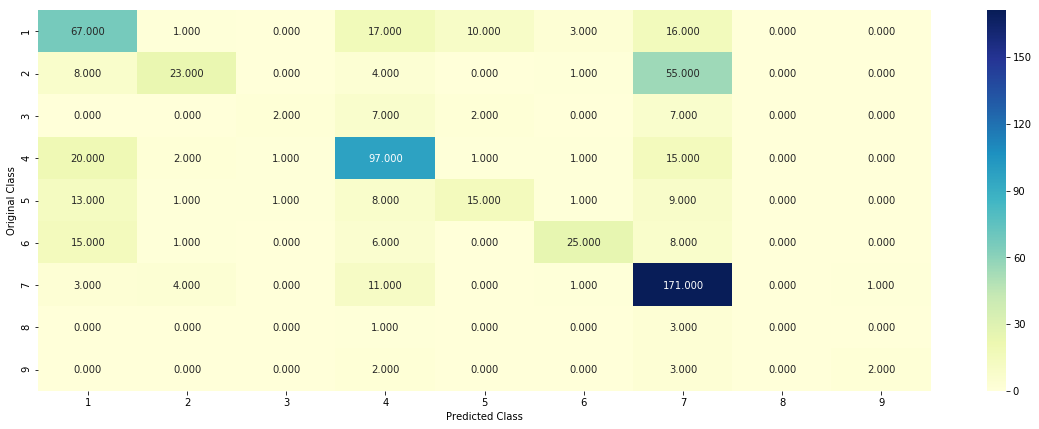

In [111]:
plot_confusion_matrix(y_test, sig_clf.predict(test_x_word2vec_1.toarray()))

The diagonal elements represent all the correctly identified values and the non-diagonal ones represent the incorrectly identified values. Accuracy can be found by adding all the correctly identified values divided by the total number of elements

### CONCLUSIONS

Different text extraction techniques were used in order to predict the genetic variation classes. These techniques are analyzed on the basis of log loss generated by different models on which it is trained on. 
We saw that, Word2Vec generates negative words and therefore cannot be used on Multinomial Naïve Bayes as it takes only positive input values. 
In order to get a lower log-loss value, hyperparameter optimization was done. Although not much difference was obtained between the log-loss values of different models which were trained in different ways, optimizing the models more by Ensembling them can improve the log-loss. The data can be tested on more Machine Learning models like Support Vector Machines, K-Nearest Neighbors, Logistic Regression, etc. We also noticed that One hot Encoding the data increases the number of features of the data. 
With more optimizations and performing model interpretability we can save Molecular Pathologists a lot of their time by making this process fully automated.

### CONTRIBUTIONS

Personal Contribution: 50%

External Source: 50%

### CITATIONS

1. Article title:	Welcome from MSKCC | Kaggle

   Website title:	Kaggle.com
   
   URL          :	https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#latest-567966
   
   
2. Article title:	Word2vec from Scratch with NumPy

   Website title:	Medium
   
   URL          :	https://towardsdatascience.com/word2vec-from-scratch-with-numpy-8786ddd49e72
  
  
3. Author	Genetics Reference

   Article title:	What is a gene mutation and how do mutations occur?
   
   Website title:	Genetics Home Reference
   
   URL          :	https://ghr.nlm.nih.gov/primer/mutationsanddisorders/genemutation
   
   
4. Article title:	Tf-idf :: A Single-Page Tutorial - Information Retrieval and Text Mining

   Website title:	Tfidf.com
   
   URL          :	http://www.tfidf.com/


5. Article title:	Gensim Word2Vec Tutorial | Kaggle

   Website title:	Kaggle.com
   
   URL          :	https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial



6. Article title:	Dealing with negative values in sklearn MultinomialNB

   Website title:	Stack Overflow
   
   URL          :	https://stackoverflow.com/questions/24169238/dealing-with-negative-values-in-sklearn-multinomialnb
   
   
7. Article title:	An Introduction to Bag-of-Words in NLP

   Website title:	Medium

   URL          :	https://medium.com/greyatom/an-introduction-to-bag-of-words-in-nlp-ac967d43b428
   
   
   
8. Article title:	3 basic approaches in Bag of Words which are better than Word Embeddings

   Website title:	Medium
   
   URL          :	https://towardsdatascience.com/3-basic-approaches-in-bag-of-words-which-are-better-than-word-embeddings-c2cbc7398016

### LICENSE

Copyright 2019 APURVA PRAVIN SALVI

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.